In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
data=pd.read_csv('/content/gdrive/My Drive/sentiment analysis/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#preprocessing the data
data.shape

(568454, 10)

In [5]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,568454.0,2.842275e+05,1.640987e+05,1.0,1.421142e+05,2.842275e+05,4.263408e+05,5.684540e+05
HelpfulnessNumerator,568454.0,1.743817e+00,7.636513e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,8.660000e+02
HelpfulnessDenominator,568454.0,2.228810e+00,8.289740e+00,0.0,0.000000e+00,1.000000e+00,2.000000e+00,9.230000e+02
Score,568454.0,4.183199e+00,1.310436e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Time,568454.0,1.296257e+09,4.804331e+07,939340800.0,1.271290e+09,1.311120e+09,1.332720e+09,1.351210e+09


In [7]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [8]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [9]:
#remove duplicate rows
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174750

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


**Splitting the dataset into positive ,negative and  neutal values i.e. neutral: score = 3 positive: score > 3 negative: score <3**

In [10]:
#Create target column using Score

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [11]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"
positive = data[data['Score'] > 3]
negative = data[data['Score'] < 3]
neutral = data[data['Score'] == 3]

In [12]:
negative.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,Negative
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,Negative
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",Negative


In [13]:
positive.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,Positive
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,Positive


In [14]:
# target column 
data[['Score', 'target']].sample(10)

,Score,target
476202,5,Positive
298274,5,Positive
231859,5,Positive
284911,2,Negative
449524,5,Positive
476844,5,Positive
242728,5,Positive
554918,5,Positive
109837,3,Neutral
280370,5,Positive


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


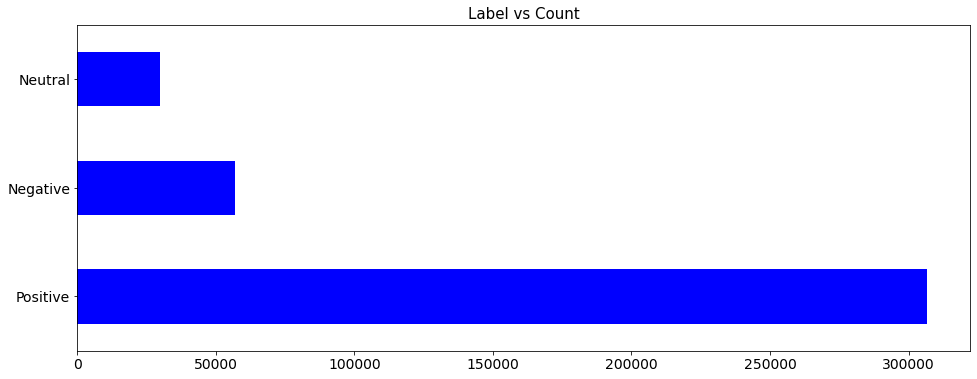

In [16]:
#Target distribution (Before)
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [17]:
#down sampling
#remove some positive and negative reviews
neutral = data.loc[data.target=="Neutral"] 

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

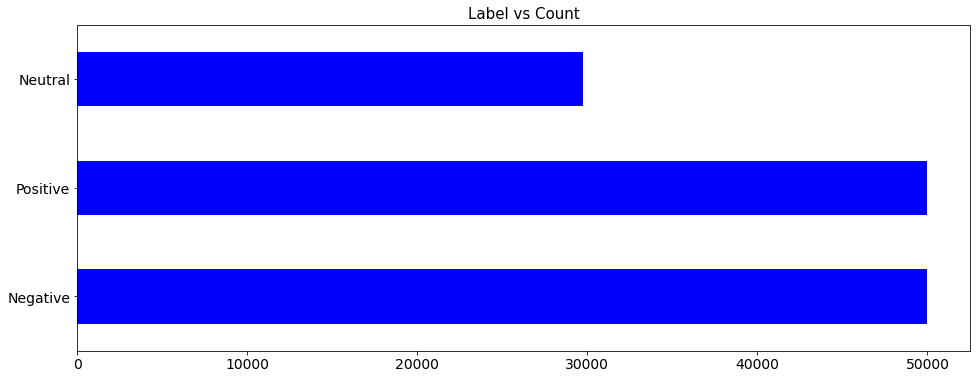

In [18]:
#Target distribution (after)
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

**STOP WORDS**

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [21]:
# stopwords
total_stopwords = set(stopwords.words('english'))
# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)
final_stopwords = total_stopwords - negative_stop_words
final_stopwords.add("one")
print(final_stopwords)

{'in', 'hasn', 'ours', 'too', 'their', 'being', "it's", 'once', 'to', 'ourselves', 'what', 'won', 'itself', 'are', 'down', 're', 'is', 'aren', 'into', 'needn', 's', 'can', 'themselves', "that'll", 'other', 'so', 'with', 'than', 'few', 'further', 'wasn', 'from', 'did', 'this', 'as', 'its', "you're", 'above', 'after', 'an', 'both', 'yours', 'myself', 'a', 'wouldn', 'under', 'between', 'against', 'were', 'mightn', 'm', 'but', "you'll", 'about', 'at', 'been', 'yourselves', 'just', 'your', 'through', 'for', "you've", 'up', 'don', 'me', 'one', 'the', 'and', 'shouldn', 'our', 'on', 'there', 'hers', 'yourself', 'ain', 'should', 'himself', 'again', 'during', 'he', 'you', 'most', "she's", 'over', 'ma', 'because', 'if', 'was', 'couldn', 'here', 'they', 'shan', 'those', 'having', 'hadn', 'why', 'when', 'we', 'isn', "should've", 'each', 'be', 'same', 'doing', 'while', 'd', 'she', 'it', 'own', 'didn', 'doesn', 'y', 'out', 'weren', 'very', 'his', 've', 'will', 'or', 'until', 'o', 'do', 'such', 'by', 

Remove unwanted words from reviews LIKE html tags,white space etc.

In [22]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [23]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [24]:
print("Before preprocessing : ")
data.Text.iloc[3]

Before preprocessing : 


'I usually avoid cold coffee drinks. They are usually too oily, sweet, milky or bland.  I was most pleasantly surprised by this drink. The touch of sugar adds more smoothness than sweetness to the robust expresso bite.  It contains no fat but has 12 grams of carbs. The small, slender can is easy to transport and the pop top makes for easy opening.<br /><br />I enjoyed this product.  In addition to using it as a beverage, a little bit enhances the flavor of chocolate baked goods (think brownies) and cuts the sweetness of buttercream frosting. So skip the run to Dunkin Donuts for an iced coffe and pop open a can of illy issimo instead.'

In [25]:
data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[3]

After preprocessing : 


'usual avoid cold coffe drink usual oili sweet milki bland pleasantli surpris drink touch sugar add smooth sweet robust expresso bite contain no fat gram carb small slender easi transport pop top make easi openingi enjoy product addit use beverag littl bit enhanc flavor chocol bake good think browni cut sweet buttercream frost skip run dunkin donut ice coff pop open illi issimo instead'

**Word** **clouds**

In [26]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

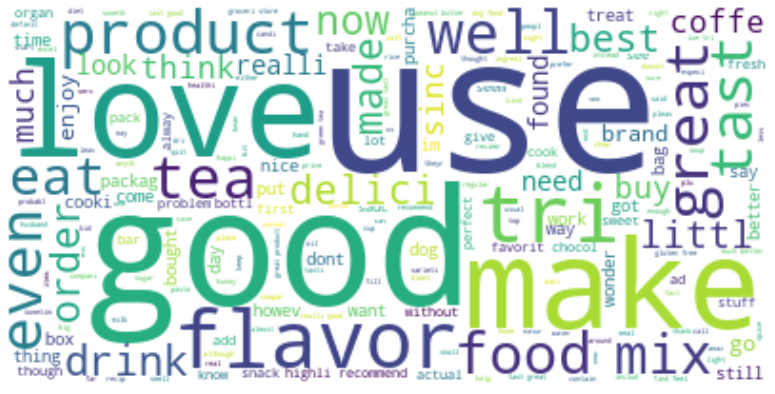

In [27]:
#Word cloud for Positive reviews
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))
generate_wcloud(text)

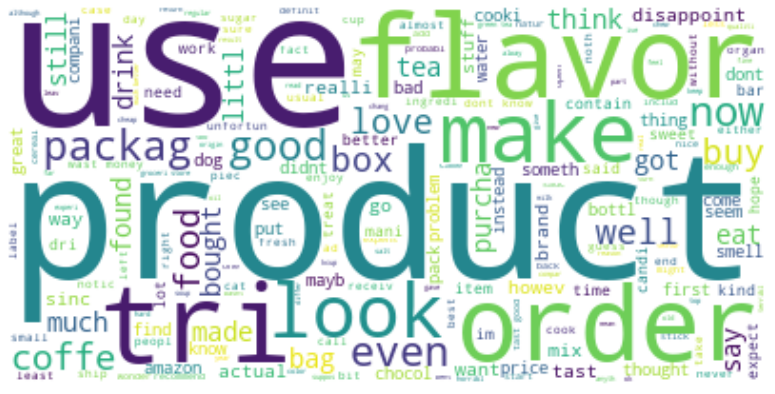

In [28]:
#Word cloud for Negative reviews
neg=data.loc[data.target=="Negative"].Text
text = " ".join(review for review in neg.astype(str))
generate_wcloud(text)

**TRAIN-TEST DATA**

In [29]:
#Train set : 70% of data
#Test set : 30% of data
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [30]:
X_train.shape, X_test.shape

((103816,), (25954,))

In [31]:
#TF_IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [32]:
#LABEL encoder
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) 

['Negative', 'Neutral', 'Positive']


In [36]:
#Model training
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

**Logistic Regression with Tf-Idf**

In [43]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.6459505278569777
Test accuracy score : 0.6415966710333667

 ----------------------------------------

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.6798951991985821
Test accuracy score : 0.6715727826153964

 ----------------------------------------

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [44]:
#Best model : Logistic Regression(C=0.1) with TfIdf data
bmodel = LogisticRegression(C=0.1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [46]:
#accuracy
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7307351467981814
Test accuracy score : 0.7157278261539647


**DEPLOYMENT**

In [50]:
#SAVE MODEL AND TRANSFORMER
import pickle
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

**Prediction on single review**

In [51]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [52]:
# negative review
review = "This chips packet is not good. I don't recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


In [53]:
# positve review
review = "This product is good.Very cheap and highly recommandable"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [54]:
# positve review
review = "Titanic is a great movie!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!
